# **Housing Price Prediction - India**

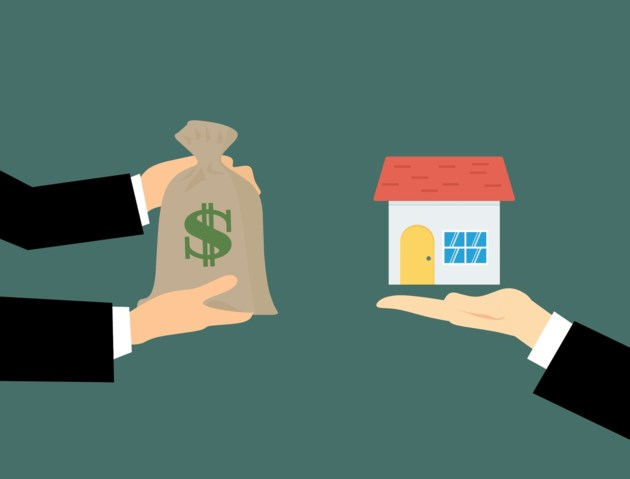

## Understanding The Problem Statement :
#### In this notebook we are going to predict the housing prices in india
##### Prediction house prices are expected to help people who plan to buy a house so they can know the price range in the future, then they can plan their finance well. In addition, house price predictions are also beneficial for property investors to know the trend of housing prices in a certain location.
##### Housing price prediction in india will be a bit challenging as this country is a mixture of various clusters which cannot be compared with any other countries and as a vast country ,The prediction might get under unexpected situations according to the land rate variation through out the nation.so come on lets jump in ..

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
import folium
print('import successful')

## Gathering Data:
##### The dataset under which the project is made is available in kaggle datasets
##### The dataset which was provided in kaggle is a combo of threee csv files,
sample_submission.csv
test.csv
train.csv
##### we'll use the train.csv which is the training dataset ,we'll use only this dataset for every steps made in this notebook and the test.csv will be used only for final prediction of the model its like a kind of task

##### now let's first read both train.csv and test.csv using pandas

In [ ]:
df = pd.read_csv('../input/house-price-prediction-challenge/train.csv')
df_test = pd.read_csv('../input/house-price-prediction-challenge/test.csv')
print('The shape of dataset is {}'.format(df.shape))
df.head()

In [ ]:
df_test.head()

## Data Cleaning

In [ ]:
df.isnull().sum()

##### seems this dataset is clean as it has no missing values.so it's like a  lit of burden reduced

In [ ]:
df['BHK_NO.'].value_counts().to_frame('counts')

##### seeing the no. of rooms column in the training_data which has upto 20 rooms and its inappropriate and seems a much outlied number and neglecting houses with prices above 15000 lakhs which is inappropriate and neglecting square_ft values to less than 300000

In [ ]:
df = df[(df['TARGET(PRICE_IN_LACS)']<15000) & 
        (df['SQUARE_FT']<300000) & (df['BHK_NO.']<=6)]

print('Shape of the dataset after neglecting the outliers {}'.format(df.shape))

# EDA:

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.corr()

#### reducing the address to the city names which will give us a deep insight of the data

In [ ]:
df['city'] = df['ADDRESS'].apply(lambda x: x.split(',')[1])
df.drop('ADDRESS', axis=1, inplace=True)
top_cities = df['city'].value_counts()[:10].keys().tolist()


df_test['city'] = df_test['ADDRESS'].apply(lambda x: x.split(',')[1])
df_test.drop('ADDRESS', axis=1, inplace=True)


In [ ]:
plt.figure()
sns.countplot('POSTED_BY', data=df)

In [ ]:
price_range = [300, 600, 1000,1500, 2500, 4000, 6000, 8000, 10000]
plt.figure(figsize=(12, 7))
sns.regplot(x='BHK_NO.', y='TARGET(PRICE_IN_LACS)', data=df)
plt.xticks([1, 2, 3, 4, 5, 6, 7])
plt.yticks(price_range)
plt.title('price w.r.t number of bhk')
plt.xlabel('number of bhk')
plt.show()

In [ ]:
plt.figure(figsize=(11, 8))
plt.subplot(2, 2, 1)
sns.countplot('READY_TO_MOVE', data=df)
plt.xlabel('')
plt.title('Ready_to_move', fontsize=12)
plt.subplot(2, 2, 2)
sns.countplot('READY_TO_MOVE', data=df[df['RERA']==0])
plt.xlabel('')
plt.title('Ready_to_move due to unapproved RERA')
plt.subplot(2, 2, 3)
sns.countplot('RESALE', data=df[df['RERA']==0])
plt.title('Resale due to unapproved RERA')
plt.xlabel('')
plt.subplot(2, 2, 4)
sns.regplot(x='RESALE',y='TARGET(PRICE_IN_LACS)', data=df)
plt.xlabel('There is a decrease in the \n price of the house\n which is being resaled')

In [ ]:
plt.figure(figsize=(12, 8))
sns.regplot('SQUARE_FT','TARGET(PRICE_IN_LACS)', data=df)

In [ ]:
owner_sales = df[df['POSTED_BY']=='Owner']
dealer_sales = df[df['POSTED_BY']=='Dealer']
builder_sales = df[df['POSTED_BY']=='Builder']
owner_price = []
dealer_price = []
builder_price = []
sq_ft = []
for bhk in range(1, 7):
    owner_cost = owner_sales['TARGET(PRICE_IN_LACS)'][owner_sales['BHK_NO.']==bhk].mean()
    dealer_cost = dealer_sales['TARGET(PRICE_IN_LACS)'][dealer_sales['BHK_NO.']==bhk].mean()
    builder_cost = builder_sales['TARGET(PRICE_IN_LACS)'][builder_sales['BHK_NO.']==bhk].mean()
    s = df['SQUARE_FT'][df['BHK_NO.']==bhk].mean()
    owner_price.append(owner_cost)
    dealer_price.append(dealer_cost)
    builder_price.append(builder_cost)
    sq_ft.append(s)
    
print(owner_price, '\n', builder_price , '\n', dealer_price)
print(sq_ft)

In [ ]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(20, 7))
gspec = gridspec.GridSpec(2, 2)
top_plot = plt.subplot(gspec[0, 1:])
bottom_bar = plt.subplot(gspec[1:, 1:])
plt.style.use('seaborn')
bhk = np.arange(1, 7)
price = [owner_price, dealer_price, builder_price]
label = ['owner', 'dealer', 'builder']
sqft = []
n=1
for i, l in zip(price, label):
    x=[]
    y=[]
    for j, k, m in zip(i, bhk, sq_ft):
        if n==3:
            if str(m)!='nan':
                sqft.append(m)
            else:
                sqft.append(0)
        if str(j)!='nan':
            x.append(k)
            y.append(j)
    top_plot.plot(x, y, label=l)
    n += 1
top_plot.set_ylabel('price in lakhs')
top_plot.set_xticklabels([])
top_plot.legend()
bottom_bar.bar(bhk, sqft, color='pink', alpha=0.7)
bottom_bar.invert_yaxis()
bottom_bar.set_xticks(bhk)
bottom_bar.set_xlabel('No. of BHK')
bottom_bar.set_ylabel('Square feet')
plt.tight_layout()

In [ ]:
cost_per_sq_ft = []
for city in (top_cities):
    a = df['SQUARE_FT'][df['city']==city].mean()
    b = df['TARGET(PRICE_IN_LACS)'][df['city']==city].mean()
    cost_per_sq_ft.append(int((b/a)*100000))
cost_per_sq_ft

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(top_cities, cost_per_sq_ft, color=['red', 'blue', 'green',
                                           'yellow', 'pink', 'orange',
                                           'cyan', '#eb8f34', '#ab34eb','#9bc4d1'])
plt.xlabel('Cities', fontsize=12)
plt.ylabel('Cost per Square_feet (in Rupees)', fontsize=12)
plt.title('Cost per Square_ft in Top Cities of India', fontsize=15)

In [ ]:
city_df = df[df['city'].isin(top_cities)]
city_df['city'].unique()

In [ ]:
plt.figure(figsize=(10, 15))
sns.barplot(x='TARGET(PRICE_IN_LACS)', y='city', data=city_df, hue='BHK_NO.', estimator=np.mean)

## Data Preprocessing

In [ ]:
df2 = pd.concat([df.drop(['city','POSTED_BY', 'BHK_OR_RK', 'LONGITUDE', 'LATITUDE'], axis=1),  
                pd.get_dummies(df['POSTED_BY'])], axis=1)
df2_test = pd.concat([df_test.drop(['city','POSTED_BY', 'BHK_OR_RK', 'LONGITUDE', 'LATITUDE'], axis=1), 
                pd.get_dummies(df_test['POSTED_BY'])], axis=1)
df2_test.reset_index(drop=True, inplace=True)

df2.reset_index(drop=True, inplace=True)
df2.head()

In [ ]:
x = df2.drop('TARGET(PRICE_IN_LACS)', axis=1).values
y = df2['TARGET(PRICE_IN_LACS)'].values

In [ ]:
x_train, x_test,y_train,  y_test = train_test_split(x, y, test_size=0.2, random_state=2)
print('x_train and x_test shapes are {} and {}'.format(x_train.shape, x_test.shape))
print('y_train and y_test shapes are {} and {}'.format(y_train.shape, y_test.shape))

# model developement

### Linear Regression

In [ ]:
model1 = LinearRegression()
model1.fit(x_train, y_train)
yhat1 = model1.predict(x_test)
print('The mean absolute error for linear regression is {}'.format(metrics.mean_absolute_error(yhat1, y_test)))
print('The Residual sum of squares (MSE): {}'.format(np.mean((yhat1-y_test)**2)))
print('The R2-Score is {}'.format(metrics.r2_score(yhat1, y_test)))

In [ ]:
ax1 = sns.distplot(y_test, hist=False, color='r', label='Actual value')
sns.distplot(yhat1, hist=False, color='b', label='predicted value', ax=ax1)

### Decision Tree Regressor

In [ ]:
model2 = DecisionTreeRegressor(random_state=1)
model2.fit(x_train, y_train)
yhat2 = model2.predict(x_test)
print('The mean_absolute error for Decision Tree Regressor is {}'.format(metrics.mean_absolute_error(yhat2, y_test)))
print('The Residual sum of squares (MSE): {}'.format(np.mean((yhat2-y_test)**2)))
print('The R2-Score is {}'.format(metrics.r2_score(yhat2, y_test)))

In [ ]:
ax2 = sns.distplot(y_test, hist=False, color='r', label='Actual value')
sns.distplot(yhat2, hist=False, color='b', label='predicted value', ax=ax2)

### Random Forest Regressor

In [ ]:
model3 = RandomForestRegressor(n_estimators=500, random_state=1)
model3.fit(x_train, y_train)
yhat3 = model3.predict(x_test)
print('The mean_absolute error for Random Forest Regressor is {}'.format(metrics.mean_absolute_error(yhat3, y_test)))
print('The Residual sum of squares (MSE): {}'.format(np.mean((yhat3-y_test)**2)))
print('The R2-Score is {}'.format(metrics.r2_score(yhat3, y_test)))

In [ ]:
ax3 = sns.distplot(y_test, hist=False, color='r', label='Actual value')
sns.distplot(yhat3, hist=False, color='b', label='predicted value', ax=ax3)

### XGBRegressor

In [ ]:
model4 = XGBRegressor(n_estimators=300, learning_rate=0.02, n_jobs=4)
model4.fit(x_train, y_train)
yhat4 = model4.predict(x_test)
print('The mean_absolute error XGBRegressor is {}'.format(metrics.mean_absolute_error(yhat4, y_test)))
print('The Residual sum of squares (MSE): {}'.format(np.mean((yhat4-y_test)**2)))
print('The R2-Score is {}'.format(metrics.r2_score(yhat4, y_test)))

In [ ]:
ax4 = sns.distplot(y_test, hist=False, color='r', label='Actual value')
sns.distplot(yhat4, hist=False, color='b', label='predicted value', ax=ax4)

#### As of the four models xgbregressor has predicted well .so using model 4 to predict the test.csv data values

In [ ]:
pred_test = model4.predict(df2_test.values)
print(pred_test[:20])
df2_test.head(20)

In [ ]:
output = pd.DataFrame({
    'TARGET(PRICE_IN_LACS)': pred_test
})

In [ ]:
output.to_csv('indian_housing_price.csv', index=False)

In [ ]:
df3 = pd.read_csv('./indian_housing_price.csv')
df3.head()

#### This housing price prediction model is better but it's not the best model to predit the housing prices. surely there is a room for improvement for the model to predict more accurately.

## Conclusion

#### Thus this is half concluded but i made this some how clear that,
#### dealers sell most of the houses than owners and builders
#### price increases with increase in square feet and with increase in number of BHK
#### dealers and builders price are higher than that of owners selling price
#### people in unapproved rera houses are ready to move and resale
#### price decreases with resaled house and unapproved house
#### price is variant with respect to the land rate and we must make further improvement in the model